# memory use with rosettasciio's EDAX reader

Memory profiler: scalene (https://github.com/plasma-umass/scalene)

## test case 

Chunked access along one dimension with a reduction along the other: see `edax_access_order.py`

3 important pieces: load the file, get a slice, calculate a reduced value: 

```python
ds = load_edax_spd(filename_base)
...
subsample = np.array(ds['data'][channel_start:channel_end,:,:])
...
reduced_value = np.sum(subsample)
```

The `data` array is a `np.memmap` array. 

Controls:
* the axis to chunk along (0 or 1 will work best)
* whether to reload `ds` between slicing
* chunksize: size of chunks per slice along axis
  
<details> 

<summary>
    example test case commands
</summary>

```shell
python -m scalene run -o ax_0_reload_1_chunksize_2.json edax_access_order.py --axis 0 --reload 1 --chunksize 2
python -m scalene run -o ax_0_reload_1_chunksize_4.json edax_access_order.py --axis 0 --reload 1 --chunksize 4
python -m scalene run -o ax_0_reload_1_chunksize_8.json edax_access_order.py --axis 0 --reload 1 --chunksize 8
python -m scalene run -o ax_0_reload_1_chunksize_16.json edax_access_order.py --axis 0 --reload 1 --chunksize 16
python -m scalene run -o ax_0_reload_1_chunksize_32.json edax_access_order.py --axis 0 --reload 1 --chunksize 32
python -m scalene run -o ax_0_reload_1_chunksize_64.json edax_access_order.py --axis 0 --reload 1 --chunksize 64
python -m scalene run -o ax_0_reload_1_chunksize_96.json edax_access_order.py --axis 0 --reload 1 --chunksize 96
python -m scalene run -o ax_0_reload_1_chunksize_128.json edax_access_order.py --axis 0 --reload 1 --chunksize 128

python -m scalene run -o ax_0_reload_0_chunksize_2.json edax_access_order.py --axis 0 --reload 0 --chunksize 2
python -m scalene run -o ax_0_reload_0_chunksize_4.json edax_access_order.py --axis 0 --reload 0 --chunksize 4
python -m scalene run -o ax_0_reload_0_chunksize_8.json edax_access_order.py --axis 0 --reload 0 --chunksize 8
python -m scalene run -o ax_0_reload_0_chunksize_16.json edax_access_order.py --axis 0 --reload 0 --chunksize 16
python -m scalene run -o ax_0_reload_0_chunksize_32.json edax_access_order.py --axis 0 --reload 0 --chunksize 32
python -m scalene run -o ax_0_reload_0_chunksize_64.json edax_access_order.py --axis 0 --reload 0 --chunksize 64
python -m scalene run -o ax_0_reload_0_chunksize_96.json edax_access_order.py --axis 0 --reload 0 --chunksize 96
python -m scalene run -o ax_0_reload_0_chunksize_128.json edax_access_order.py --axis 0 --reload 0 --chunksize 128
```

</details>


### conclusions 

* Reloading between reads results in better memory scaling: `np.memmap` is likely cacheing data?
* Scalene doesn't report a concept of a "heap" size like `memray` does: does this matter?



In [1]:
import os 
import json
import matplotlib.pyplot as plt 
import pandas as pd 

In [11]:
chunksizes = (2, 4, 8, 16, 32, 64, 96, 128)

def get_mem_results(axid:int, chunksize:int, reload:int):
    filebase = f"ax_{axid}_reload_{reload}_chunksize_{chunksize}.json"
    fi = os.path.join('scalene-outputs', filebase) 
    
    with open(fi, 'r') as fh: 
        results = json.load(fh) 

    df = pd.DataFrame(results['samples'], columns=['t','mem'])
    df['dt_s'] = (df['t'] - df['t'].iloc[0]) / 1e9
    return df 

def process_test_case(axid:int, reload:int, pltax: plt.Axes | None = None):

    peak_mem = [] 
    execution_time = []
    
    for chunksize in chunksizes:
        df = get_mem_results(axid, chunksize, reload)        
        peak_mem.append(df['mem'].max())    
        execution_time.append(df['dt_s'].max())

        if pltax:
            pltax.plot(df['dt_s'], df['mem'], label=f"{chunksize}")

    return peak_mem, execution_time 
        

## comparing reload behavior, chunksizes with chunking along axis 0 

Text(0, 0.5, 'memory use')

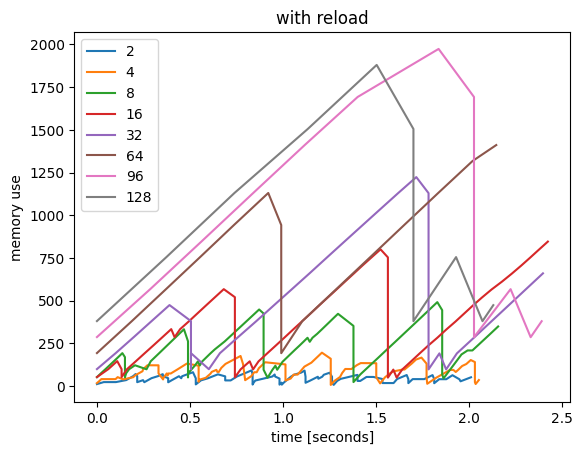

In [3]:
f, axs = plt.subplots(1)

peak_mem, execution_time = process_test_case(0, 1, axs)

plt.legend()    
plt.title('with reload')
plt.xlabel("time [seconds]")
plt.ylabel("memory use")

Text(0, 0.5, 'memory use')

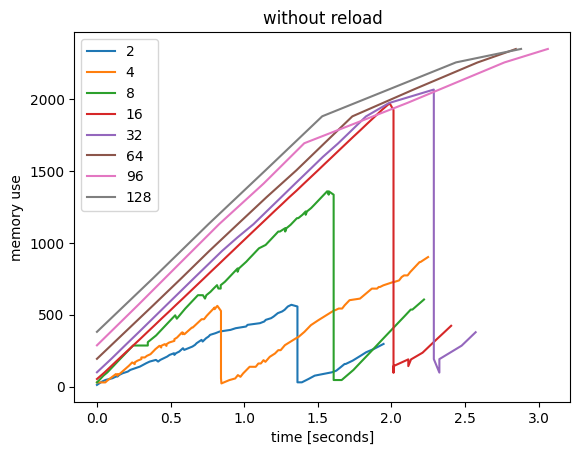

In [4]:
f, axs = plt.subplots(1)

peak_mem_noreload, execution_time_noreload = process_test_case(0, 0, axs)

plt.legend()    
plt.title('without reload')
plt.xlabel("time [seconds]")
plt.ylabel("memory use")

Text(0.5, 0, 'chunksize')

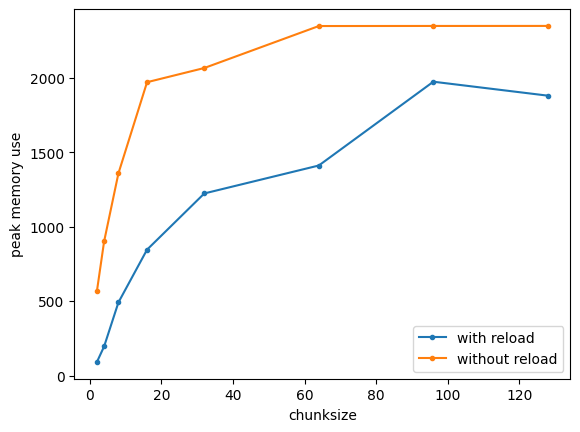

In [5]:
plt.plot(chunksizes, peak_mem, label='with reload', marker='.')
plt.plot(chunksizes, peak_mem_noreload, label='without reload', marker='.')
plt.legend()

plt.ylabel('peak memory use')
plt.xlabel('chunksize')

Text(0.5, 0, 'chunksize')

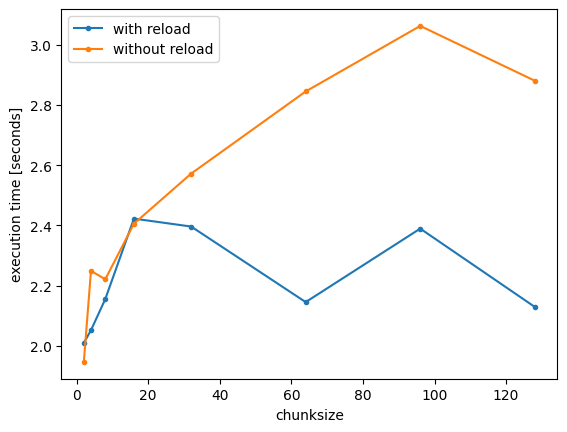

In [6]:
plt.plot(chunksizes, execution_time, label='with reload', marker='.')
plt.plot(chunksizes, execution_time_noreload, label='without reload', marker='.')
plt.legend()

plt.ylabel('execution time [seconds]')
plt.xlabel('chunksize')

## along axis 1

Text(0, 0.5, 'memory use')

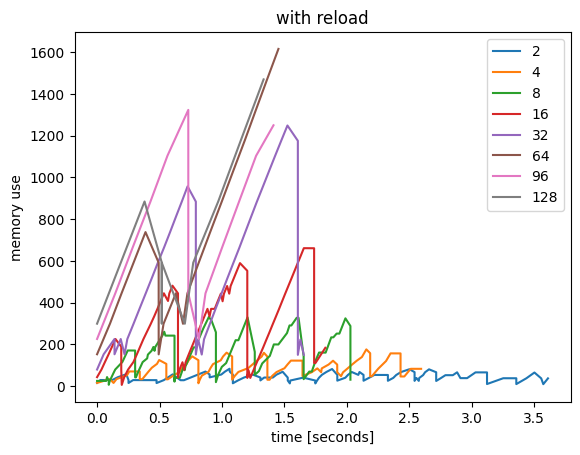

In [7]:
f, axs = plt.subplots(1)

peak_mem, execution_time = process_test_case(1, 1, axs)

plt.legend()    
plt.title('with reload')
plt.xlabel("time [seconds]")
plt.ylabel("memory use")

Text(0, 0.5, 'memory use')

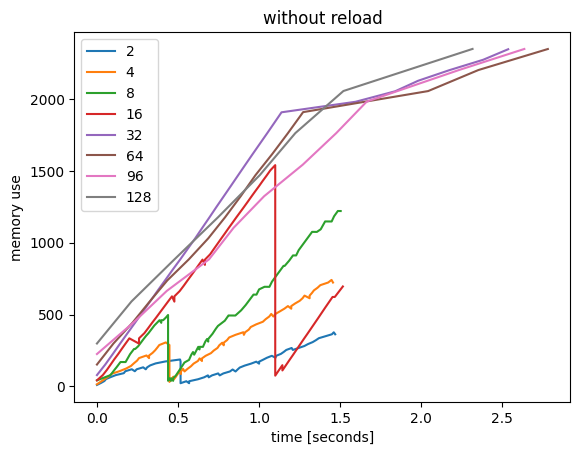

In [8]:
f, axs = plt.subplots(1)

peak_mem_noreload, execution_time_noreload = process_test_case(1, 0, axs)

plt.legend()    
plt.title('without reload')
plt.xlabel("time [seconds]")
plt.ylabel("memory use")

Text(0.5, 0, 'chunksize')

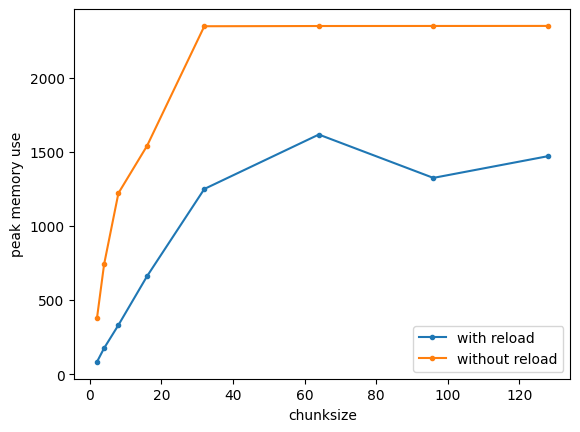

In [9]:
plt.plot(chunksizes, peak_mem, label='with reload', marker='.')
plt.plot(chunksizes, peak_mem_noreload, label='without reload', marker='.')
plt.legend()

plt.ylabel('peak memory use')
plt.xlabel('chunksize')

Text(0.5, 0, 'chunksize')

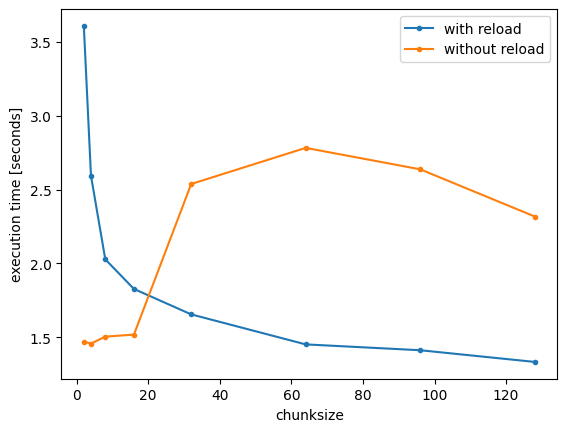

In [10]:
plt.plot(chunksizes, execution_time, label='with reload', marker='.')
plt.plot(chunksizes, execution_time_noreload, label='without reload', marker='.')
plt.legend()

plt.ylabel('execution time [seconds]')
plt.xlabel('chunksize')

## along axis 2

Text(0, 0.5, 'memory use')

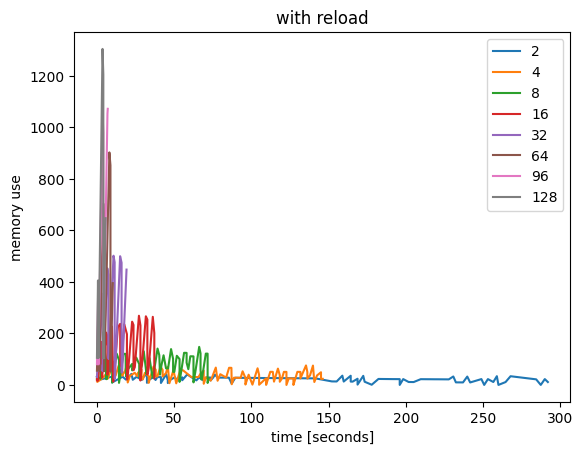

In [12]:
f, axs = plt.subplots(1)

peak_mem, execution_time = process_test_case(2, 1, axs)

plt.legend()    
plt.title('with reload')
plt.xlabel("time [seconds]")
plt.ylabel("memory use")

Text(0, 0.5, 'memory use')

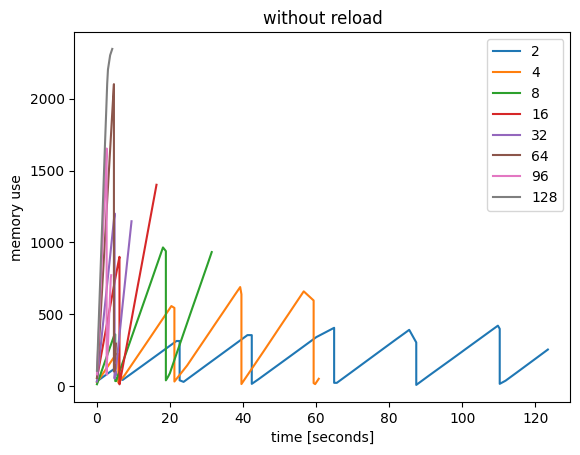

In [13]:
f, axs = plt.subplots(1)

peak_mem_noreload, execution_time_noreload = process_test_case(2, 0, axs)

plt.legend()    
plt.title('without reload')
plt.xlabel("time [seconds]")
plt.ylabel("memory use")

Text(0.5, 0, 'chunksize')

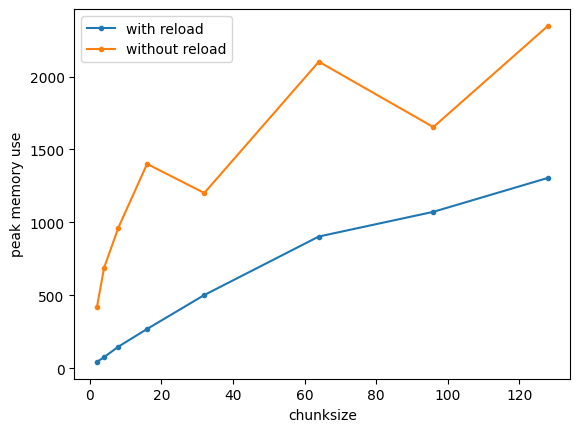

In [14]:
plt.plot(chunksizes, peak_mem, label='with reload', marker='.')
plt.plot(chunksizes, peak_mem_noreload, label='without reload', marker='.')
plt.legend()

plt.ylabel('peak memory use')
plt.xlabel('chunksize')

Text(0.5, 0, 'chunksize')

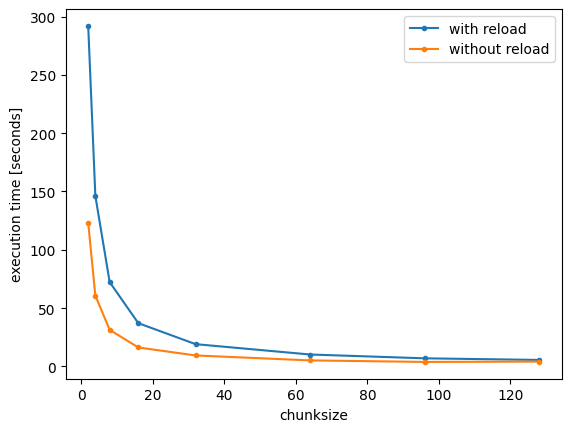

In [15]:
plt.plot(chunksizes, execution_time, label='with reload', marker='.')
plt.plot(chunksizes, execution_time_noreload, label='without reload', marker='.')
plt.legend()

plt.ylabel('execution time [seconds]')
plt.xlabel('chunksize')

## Comparing axis 


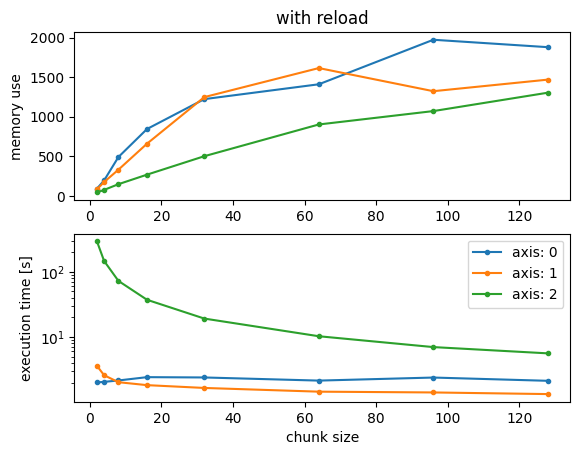

In [26]:
f, axs = plt.subplots(nrows=2,ncols=1) 

for axid in range(3):    
    peak_mem, execution_time = process_test_case(axid, 1)

    axs[0].plot(chunksizes, peak_mem, label=f"axis: {axid}", marker='.')
    axs[1].semilogy(chunksizes, execution_time, label=f"axis: {axid}", marker='.')


axs[0].set_title('with reload')
axs[0].set_ylabel('memory use')
axs[1].set_ylabel('execution time [s]')
axs[1].set_xlabel('chunk size')
plt.legend()

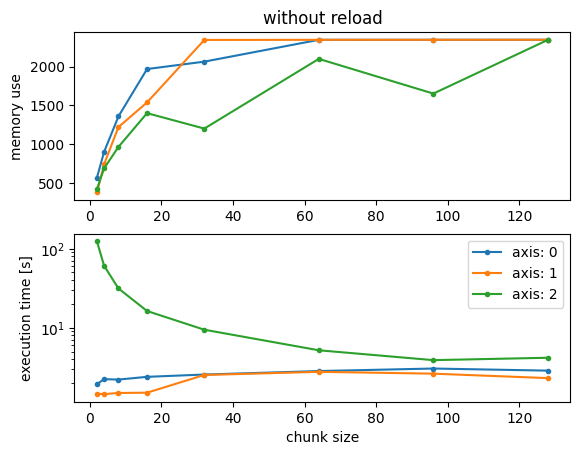

In [27]:
f, axs = plt.subplots(nrows=2,ncols=1) 

for axid in range(3):    
    peak_mem, execution_time = process_test_case(axid, 0)

    axs[0].plot(chunksizes, peak_mem, label=f"axis: {axid}", marker='.')
    axs[1].semilogy(chunksizes, execution_time, label=f"axis: {axid}", marker='.')


axs[0].set_title('without reload')
axs[0].set_ylabel('memory use')
axs[1].set_ylabel('execution time [s]')
axs[1].set_xlabel('chunk size')
plt.legend()